# OCR-Devanagari-CRNN — Dataset Analysis & Training Pipeline

This notebook creates an OCR for Devanagari using CRNN + LSTM, leveraging the HuggingFace dataset "Sakonii/nepalitext-language-model-dataset" to synthesize training images.

In [1]:
!pip install --upgrade pip setuptools
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import os
import glob
import torch
import torch.nn as nn
import freetype
import uharfbuzz as hb
import cv2
from collections import Counter

In [2]:
# Load the NepaliText dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")
train_texts = dataset["train"]["text"]
print(f"Loaded dataset with {len(train_texts)} training samples")

Loaded dataset with 13141222 training samples


In [144]:
# Clean character function
def clean_char(c):
    if c in ["\n", "\t", "\r"]:
        return ""
    if ord(c) in [8203, 8204, 8205, 8206, 8207]:
        return ""
    if 2304 <= ord(c) <= 2431:  # Devanagari block
        return c
    if c.isprintable():
        return c
    return ""

# Character frequency analysis
char_freq = Counter()
for text in train_texts:
    if isinstance(text, str):
        cleaned = "".join(clean_char(c) for c in text)
        char_freq.update(cleaned)

print(f"✓ Unique cleaned characters: {len(char_freq)}")

# Top 50 characters
top_50 = char_freq.most_common(50)
chars, freqs = zip(*top_50)

plt.figure(figsize=(14, 6))
plt.bar(chars, freqs)
plt.xticks(rotation=90, fontsize=12)
plt.title("Top 50 Characters (Cleaned)")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Step 1: Extract 5000 Nepali Words

Extract unique Devanagari words from the dataset for training.

In [12]:
# Extract Devanagari words
def extract_nepali_words(text):
    """Extract Devanagari words from text."""
    if not isinstance(text, str):
        return []
    matches = re.findall(r"[\u0900-\u097F]+", text)
    return [w for w in matches if 2 <= len(w) <= 30]

all_words = set()
print("Extracting Nepali words from dataset...")
for i, text in enumerate(train_texts):
    words = extract_nepali_words(text)
    all_words.update(words)
    if (i + 1) % 10000 == 0:
        print(f"  Processed {i + 1} texts, found {len(all_words)} unique words")

# Sample 5000 words for training
all_words = list(all_words)
random.shuffle(all_words)
training_words = all_words[:5000]

print(f"\n✓ Total unique words: {len(all_words)}")
print(f"✓ Using {len(training_words)} words for training")
print(f"✓ Sample words: {training_words[:10]}")

Extracting Nepali words from dataset...
  Processed 10000 texts, found 49361 unique words
  Processed 20000 texts, found 77417 unique words
  Processed 30000 texts, found 100764 unique words
  Processed 40000 texts, found 119936 unique words
  Processed 50000 texts, found 137609 unique words
  Processed 60000 texts, found 153427 unique words
  Processed 70000 texts, found 167843 unique words
  Processed 80000 texts, found 182163 unique words
  Processed 90000 texts, found 195560 unique words
  Processed 100000 texts, found 208380 unique words
  Processed 110000 texts, found 220954 unique words
  Processed 120000 texts, found 232162 unique words
  Processed 130000 texts, found 243317 unique words
  Processed 140000 texts, found 254115 unique words
  Processed 150000 texts, found 264583 unique words
  Processed 160000 texts, found 274815 unique words
  Processed 170000 texts, found 285196 unique words
  Processed 180000 texts, found 294661 unique words
  Processed 190000 texts, found 305

## Step 2: Synthetic Dataset Generator

HarfBuzz-based generator for proper Devanagari shaping.

In [5]:
from PIL import ImageFilter


class SyntheticHarfBuzzOCRDatasetGenerator:
    """Generate synthetic OCR dataset with HarfBuzz shaping."""

    def __init__(
        self,
        strings,
        fonts_dir="fonts",
        output_dir="data/word_images",
        font_size_range=(40, 56),
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background_mode="random",
        max_image_size=1024
    ):
        self.strings = strings
        self.fonts = glob.glob(os.path.join(fonts_dir, "**/*.ttf"), recursive=True)
        if not self.fonts:
            raise ValueError(f"No fonts found in {fonts_dir}")

        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self.font_size_range = font_size_range
        self.random_blur = random_blur
        self.random_noise = random_noise
        self.random_rotate = random_rotate
        self.random_distortion = random_distortion
        self.background_mode = background_mode
        self.MAX_SIZE = max_image_size

    def _clamp_image_size(self, img):
        w, h = img.size
        if w > self.MAX_SIZE or h > self.MAX_SIZE:
            img.thumbnail((self.MAX_SIZE, self.MAX_SIZE), Image.LANCZOS)
        return img

    def generate_dataset(self):
        for idx, text in enumerate(self.strings, start=1):
            img = self.render_text_image(text)
            image_path = os.path.join(self.output_dir, f"{idx:05d}.png")
            label_path = os.path.join(self.output_dir, f"{idx:05d}.txt")
            img.save(image_path)
            with open(label_path, "w", encoding="utf-8") as f:
                f.write(text)
            if idx % 500 == 0:
                print(f"  [{idx}/{len(self.strings)}] Generated images")

    def render_text_image(self, text, padding=20):
        font_path = random.choice(self.fonts)
        font_size = random.randint(*self.font_size_range)
        face = freetype.Face(font_path)
        face.set_char_size(font_size * 64)

        # HarfBuzz shaping
        hb_blob = hb.Blob.from_file_path(font_path)
        hb_face = hb.Face(hb_blob, 0)
        hb_font = hb.Font(hb_face)
        hb_font.scale = (face.size.ascender, face.size.ascender)

        buf = hb.Buffer()
        buf.add_str(text)
        buf.guess_segment_properties()
        hb.shape(hb_font, buf)

        infos = buf.glyph_infos
        positions = buf.glyph_positions

        width = sum(pos.x_advance for pos in positions) // 64 + 2*padding
        height = font_size + 2*padding

        if self.background_mode == "white":
            img = Image.new("RGB", (width, height), "white")
        elif self.background_mode == "lightgray":
            img = Image.new("RGB", (width, height), "lightgray")
        else:
            arr = np.random.randint(200, 255, (height, width, 3), dtype=np.uint8)
            img = Image.fromarray(arr)

        x, y = padding, padding + font_size

        for info, pos in zip(infos, positions):
            glyph_index = info.codepoint
            face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
            bitmap = face.glyph.bitmap
            top = face.glyph.bitmap_top
            left = face.glyph.bitmap_left

            if bitmap.width > 0 and bitmap.rows > 0:
                glyph_img = Image.frombytes("L", (bitmap.width, bitmap.rows), bytes(bitmap.buffer))
                colored_glyph = Image.new("RGB", glyph_img.size, "black")
                img.paste(colored_glyph, (int(x + left), int(y - top)), glyph_img)

            x += pos.x_advance / 64
            y -= pos.y_advance / 64

        img = self._clamp_image_size(img)

        # --- FIXED BLUR SECTION ---
        from PIL import ImageFilter

        if self.random_blur and random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))


        if self.random_rotate:
            angle = random.randint(-7, 7)
            img = img.rotate(angle, expand=True, fillcolor="white")
            img = self._clamp_image_size(img)

        if self.random_distortion:
            img = self.perspective_distortion(img)

        if self.random_noise:
            img = self.add_noise(img)

        return img

    def perspective_distortion(self, img):
        img = self._clamp_image_size(img)
        w, h = img.size
        arr = np.array(img)
        shift = min(w, h) * 0.1

        pts1 = np.float32([[0,0],[w,0],[0,h],[w,h]])
        pts2 = np.float32([
            [random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
        ])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(arr, matrix, (w,h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))
        return Image.fromarray(warped)

    def add_noise(self, img):
        arr = np.array(img).astype(np.float32)
        if random.random() < 0.5:
            arr += np.random.normal(0, 10, arr.shape)
        if random.random() < 0.5:
            amount = 0.02
            num_salt = int(arr.size * amount * 0.5)
            num_pepper = int(arr.size * amount * 0.5)
            coords = [np.random.randint(0, i - 1, num_salt) for i in arr.shape]
            arr[tuple(coords)] = 255
            coords = [np.random.randint(0, i - 1, num_pepper) for i in arr.shape]
            arr[tuple(coords)] = 0
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8))

## Step 3: Generate Dataset

In [6]:
print("=" * 70)
print("GENERATING SYNTHETIC DATASET (5000 WORD SAMPLES)")
print("=" * 70)

generator = SyntheticHarfBuzzOCRDatasetGenerator(
    strings=training_words,
    fonts_dir="fonts",
    output_dir="data/word_images",
    font_size_range=(40, 56),
    random_blur=True,
    random_noise=True,
    random_rotate=True,
    random_distortion=True,
    background_mode="random",
    max_image_size=1024
)

generator.generate_dataset()

print("\n✓ DATASET GENERATION COMPLETE!")
print("=" * 70)

# Verify
output_dir = "data/word_images"
image_files = [f for f in os.listdir(output_dir) if f.endswith(".png")]
print(f"✓ Generated {len(image_files)} images")

GENERATING SYNTHETIC DATASET (5000 WORD SAMPLES)
  [500/5000] Generated images
  [1000/5000] Generated images
  [1500/5000] Generated images
  [2000/5000] Generated images
  [2500/5000] Generated images
  [3000/5000] Generated images
  [3500/5000] Generated images
  [4000/5000] Generated images
  [4500/5000] Generated images
  [5000/5000] Generated images

✓ DATASET GENERATION COMPLETE!
✓ Generated 5000 images


## Step 4: Create Charset

In [13]:
# Extract unique characters
charset = set()
for word in training_words:
    charset.update(word)
charset = sorted(list(charset))

with open("charset.txt", "w", encoding="utf-8") as f:
    f.write("".join(charset))

print(f"✓ Charset: {len(charset)} unique characters")
print(f"✓ num_classes = {len(charset) + 1} (including CTC blank)")

✓ Charset: 79 unique characters
✓ num_classes = 80 (including CTC blank)


## Step 5: Model Architecture

In [14]:
import torch
import torch.nn as nn

# -------------------------------
# Basic Residual Block
# -------------------------------
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

# -------------------------------
# Custom ResNet-like Feature Extractor
# -------------------------------
class ResNetCNN(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(img_channels, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        # Residual layers
        self.layer1 = self._make_layer(64, 128, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, 512, num_blocks=2, stride=2)

        # Adaptive pooling to height=1
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [BasicBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.adaptive_pool(x)  # [B, C, 1, W]
        x = x.squeeze(2)           # [B, C, W]
        x = x.permute(2, 0, 1)     # [W, B, C] for BiLSTM
        return x

# -------------------------------
# BiLSTM and OCRModel
# -------------------------------
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, bidirectional=True)
        self.embedding = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        return self.embedding(recurrent)

class OCRModelResNetScratch(nn.Module):
    def __init__(self, num_classes, img_channels=1, hidden_size=256):
        super().__init__()
        self.cnn = ResNetCNN(img_channels)
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        features = self.cnn(x)
        return self.rnn(features)

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)

print("✓ Custom ResNet-style CRNN defined (from scratch, no pretrained)")


✓ Custom ResNet-style CRNN defined (from scratch, no pretrained)


## Step 6: Create Config & Start Training

In [15]:
import subprocess
import sys

# Create config
config_content = f"""# CRNN OCR Configuration
num_classes: {len(charset) + 1}
num_channels: 1
hidden_size: 256

img_height: 32
img_width: 256

batch_size: 32
epochs: 100
learning_rate: 0.001
weight_decay: 1e-5
scheduler_step: 15
scheduler_gamma: 0.5

train_samples: 5000
samples_per_word: 1
fonts_dir: "fonts"
output_dir: "data/word_images"
charset_path: "charset.txt"
"""

with open("config.yaml", "w") as f:
    f.write(config_content)

print("✓ config.yaml created")
print(f"✓ Charset size: {len(charset)} → {len(charset) + 1} classes")
print("\nTo start training, run: python scripts/train_word_ocr.py")

✓ config.yaml created
✓ Charset size: 79 → 80 classes

To start training, run: python scripts/train_word_ocr.py


## Summary

Pipeline complete:
- ✅ Extracted 5000 unique Nepali words
- ✅ Generated synthetic images (HarfBuzz + augmentations)
- ✅ Created charset.txt
- ✅ Defined OCR model (CRNN + BiLSTM + CTC)
- ✅ Ready for training

In [16]:
import yaml

with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

print("Loaded config:", cfg)


Loaded config: {'num_classes': 80, 'num_channels': 1, 'hidden_size': 256, 'img_height': 32, 'img_width': 256, 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.001, 'weight_decay': '1e-5', 'scheduler_step': 15, 'scheduler_gamma': 0.5, 'train_samples': 5000, 'samples_per_word': 1, 'fonts_dir': 'fonts', 'output_dir': 'data/word_images', 'charset_path': 'charset.txt'}


In [17]:
with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# FIX the incorrect type
cfg["weight_decay"] = float(cfg["weight_decay"])


In [18]:
import numpy as np


In [19]:
import os

root_dir = "data/word_images"
all_texts = []

# Collect all text from .txt files
for f in os.listdir(root_dir):
    if f.endswith(".txt"):
        with open(os.path.join(root_dir, f), "r", encoding="utf-8") as file:
            text = file.read().strip()
            all_texts.append(text)

# Extract unique characters
charset = set()
for text in all_texts:
    charset.update(text)

charset = sorted(list(charset))
print(f"Total unique characters in dataset: {len(charset)}")

# Save to charset.txt
with open("charset.txt", "w", encoding="utf-8") as f:
    for c in charset:
        f.write(c + "\n")

print("✓ charset.txt generated with all dataset characters")


Total unique characters in dataset: 78
✓ charset.txt generated with all dataset characters


In [23]:
dataset = OCRDataset(train_files, root_dir, "charset.txt", img_h=cfg["img_height"], img_w=cfg["img_width"], debug=True)

# Check first few samples
for i in range(5):
    img, label = dataset[i]
    print(label)


NameError: name 'train_files' is not defined

In [30]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------
# 1️⃣ Build charset from dataset
# ----------------------------
root_dir = "data/word_images"
all_texts = []

for f in os.listdir(root_dir):
    if f.endswith(".txt"):
        with open(os.path.join(root_dir, f), "r", encoding="utf-8") as file:
            text = file.read().strip()
            all_texts.append(text)

# Extract unique characters
charset = sorted(list(set("".join(all_texts))))
with open("charset.txt", "w", encoding="utf-8") as f:
    for c in charset:
        f.write(c + "\n")

num_classes = len(charset) + 1  # +1 for CTC blank

print(f"✓ charset generated: {num_classes} classes (including blank)")


✓ charset generated: 79 classes (including blank)


# 1. OCR Dataset Class

In [31]:
class OCRDataset(Dataset):
    def __init__(self, files, root, charset_path, img_h, img_w, debug=False):
        self.files = files
        self.root = root
        self.img_h = img_h
        self.img_w = img_w
        self.debug = debug

        with open(charset_path, "r", encoding="utf-8") as f:
            self.charset = ["blank"] + [c.strip() for c in f.readlines() if c.strip()]
        self.char_to_idx = {c: i for i, c in enumerate(self.charset)}

    def encode(self, text):
        indices = [self.char_to_idx[c] for c in text if c in self.char_to_idx]
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.root, img_name)
        txt_path = os.path.join(self.root, img_name[:-4] + ".txt")

        img = Image.open(img_path).convert("L")
        img = img.resize((self.img_w, self.img_h), Image.LANCZOS)
        img = np.array(img)
        img = torch.from_numpy(img).float().unsqueeze(0) / 255.0

        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        label = self.encode(text)

        if self.debug:
            print(f"[{idx}] {img_name}: text='{text}', label={label}, len={len(label)}")

        return img, label


def ocr_collate(batch):
    imgs, labels, label_lens = [], [], []

    for img, label in batch:
        if len(label) == 0:
            continue
        imgs.append(img)
        labels.append(label)
        label_lens.append(len(label))

    if len(imgs) == 0:
        raise ValueError("All labels in this batch are empty. Check charset or txt files.")

    imgs = torch.stack(imgs)
    labels = torch.cat(labels)
    label_lens = torch.tensor(label_lens, dtype=torch.int32)

    return imgs, labels, label_lens


# Collate Function (for CTC)

In [32]:
# def ocr_collate(batch):
#     """
#     batch: list of (img, label)
#     Returns:
#       imgs: [B, 1, H, W]
#       labels: concatenated 1D tensor of all labels
#       label_lens: length of each label in batch
#     """
#     imgs, labels, label_lens = [], [], []

#     for img, label in batch:
#         imgs.append(img)
#         labels.append(label)
#         label_lens.append(len(label))

#     imgs = torch.stack(imgs)
#     labels = torch.cat(labels)
#     label_lens = torch.tensor(label_lens, dtype=torch.int32)

#     return imgs, labels, label_lens


# 3. Load Data

In [33]:
all_images = [f for f in os.listdir(root_dir) if f.endswith(".png")]
all_samples = [f for f in all_images if os.path.exists(os.path.join(root_dir, f[:-4] + ".txt"))]

train_files, val_files = train_test_split(all_samples, test_size=0.1, random_state=42)

train_dataset = OCRDataset(train_files, root_dir, "charset.txt", cfg["img_height"], cfg["img_width"], debug=False)
val_dataset = OCRDataset(val_files, root_dir, "charset.txt", cfg["img_height"], cfg["img_width"], debug=False)

train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True, collate_fn=ocr_collate, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=cfg["batch_size"], shuffle=False, collate_fn=ocr_collate, num_workers=2)


In [27]:
# imgs, labels, label_lens = next(iter(train_loader))
# print("Image batch shape:", imgs.shape)       # [B, 1, H, W]
# print("Concatenated labels:", labels[:20])
# print("Label lengths:", label_lens)


In [34]:
all_images = [
    os.path.join(root_dir, f)
    for f in os.listdir(root_dir)
    if f.endswith(".png")
]

all_samples = [
    os.path.join(root_dir, f)
    for f in os.listdir(root_dir)
    if f.endswith(".png") and os.path.exists(os.path.join(root_dir, f[:-4] + ".txt"))
]


In [28]:
import torch

# Choose GPU index here
gpu_id = 1  # Change this to 0, 1, 2, or 3 depending on which GPU you want

device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ({torch.cuda.get_device_name(gpu_id)})")

# Example: move model to selected GPU
model = model.to(device)


Using device: cuda:1 (NVIDIA GeForce RTX 2080 Ti)


NameError: name 'model' is not defined

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg["learning_rate"], weight_decay=cfg["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg["scheduler_step"], gamma=cfg["scheduler_gamma"])

EPOCHS = cfg["epochs"]
train_loss_history, val_loss_history = [], []

for epoch in range(1, EPOCHS + 1):
    # -------------------
    # Training
    # -------------------
    model.train()
    total_train_loss = 0

    for imgs, targets, target_lens in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        batch_size = imgs.size(0)

        preds = model(imgs)  # [T, B, C]
        pred_lens = torch.full((batch_size,), fill_value=preds.size(0), dtype=torch.int32).to(device)

        loss = model.compute_ctc_loss(preds, targets, pred_lens, target_lens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # -------------------
    # Validation
    # -------------------
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for imgs, targets, target_lens in val_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            batch_size = imgs.size(0)

            preds = model(imgs)
            pred_lens = torch.full((batch_size,), fill_value=preds.size(0), dtype=torch.int32).to(device)

            loss = model.compute_ctc_loss(preds, targets, pred_lens, target_lens)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    # Scheduler step
    scheduler.step()

    print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# -------------------
# Plot training curve
# -------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CRNN-CTC Training Curve")
plt.legend()
plt.show()


Using device: cuda


NameError: name 'model' is not defined

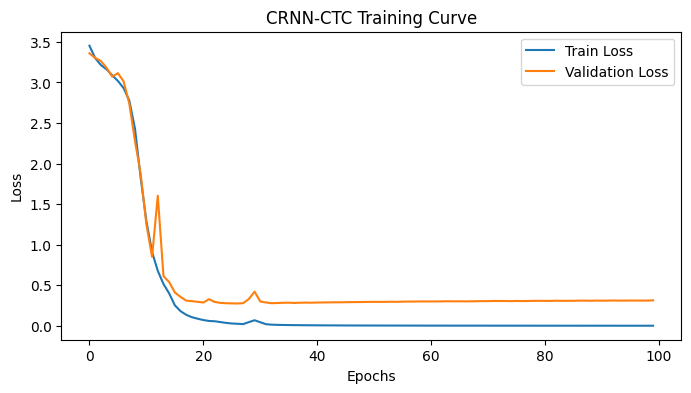

In [180]:
plt.figure(figsize=(8,4))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CRNN-CTC Training Curve")
plt.legend()
plt.savefig("training_loss_curve_resnet.png")

plt.show()


# 4. Training Script

# Saving the model

In [186]:
os.makedirs("checkpoints", exist_ok=True)
save_path = "checkpoints/nepali_crnn_ctc.pth"
torch.save(model.state_dict(), save_path)
print("✓ Model saved at", save_path)


✓ Model saved at checkpoints/nepali_crnn_ctc.pth


In [187]:
import torch
import editdistance

# ---------------------------
# 1️⃣ Decode predictions
# ---------------------------
def decode_predictions(preds, charset, blank_idx=0):
    """
    Greedy CTC decoding
    preds: [T, B, C] logits
    Returns:
      pred_texts: list of strings
      confs: average probability per predicted character
    """
    pred_texts = []
    confs = []

    preds = preds.softmax(2)  # convert logits to probabilities
    preds_idx = preds.argmax(2).transpose(0, 1)  # [B, T]

    for b, seq in enumerate(preds_idx):
        text = ""
        last_idx = None
        char_probs = []

        for t, idx in enumerate(seq):
            prob = preds[t, b, idx].item()
            if idx != blank_idx and idx != last_idx:
                text += charset[idx]
                char_probs.append(prob)
            last_idx = idx

        pred_texts.append(text)
        confs.append(sum(char_probs) / len(char_probs) if char_probs else 0.0)

    return pred_texts, confs

# ---------------------------
# 2️⃣ CER and WER
# ---------------------------
def compute_cer(ref, hyp):
    return editdistance.eval(hyp, ref) / max(len(ref), 1)

def compute_wer(ref, hyp):
    return editdistance.eval(hyp.split(), ref.split()) / max(len(ref.split()), 1)

# ---------------------------
# 3️⃣ Evaluation function
# ---------------------------
def evaluate_ocr(model, dataloader, charset, device):
    model.eval()
    total_cer, total_wer, total_conf, n_samples = 0.0, 0.0, 0.0, 0

    with torch.no_grad():
        for imgs, labels, label_lens in dataloader:
            imgs = imgs.to(device)

            # Forward pass
            preds = model(imgs)  # [T, B, C]

            # Decode predictions
            pred_texts, confs = decode_predictions(preds, charset)

            # Decode ground truth
            gt_texts = []
            idx = 0
            for length in label_lens:
                chars = [charset[c.item()] for c in labels[idx: idx + length]]
                gt_texts.append("".join(chars))
                idx += length

            # Compute metrics
            for gt, pred, conf in zip(gt_texts, pred_texts, confs):
                total_cer += compute_cer(gt, pred)
                total_wer += compute_wer(gt, pred)
                total_conf += conf
                n_samples += 1

    avg_cer = total_cer / n_samples
    avg_wer = total_wer / n_samples
    avg_conf = total_conf / n_samples

    print(f"Avg CER: {avg_cer:.4f}, Avg WER: {avg_wer:.4f}, Avg Confidence: {avg_conf:.4f}")
    return avg_cer, avg_wer, avg_conf

# ---------------------------
# 4️⃣ Run evaluation
# ---------------------------
# Make sure charset includes 'blank' at index 0
charset = ["blank"] + [c for c in open(cfg["charset_path"], "r", encoding="utf-8").read()]

avg_cer, avg_wer, avg_conf = evaluate_ocr(
    model=model,
    dataloader=train_loader,  # or validation/test loader
    charset=charset,
    device=device
)


Avg CER: 0.9648, Avg WER: 0.9541, Avg Confidence: 0.0966


# Plot the curve

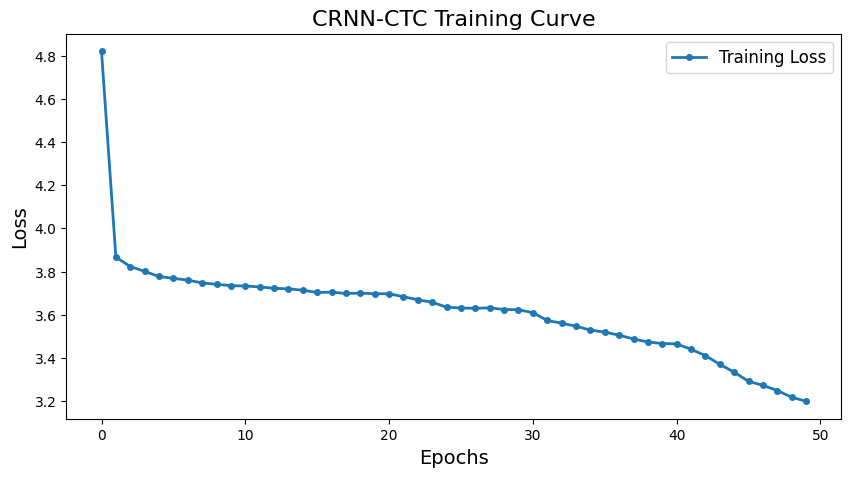

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot the training loss with markers
plt.plot(
    loss_history,
    label="Training Loss",
    color="#1f77b4",   # blue
    linestyle="-",
    marker="o",
    markersize=4,
    linewidth=2
)

# Labels and title
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("CRNN-CTC Training Curve", fontsize=16)

# Disable grid lines
plt.grid(False)

# Legend
plt.legend(fontsize=12)

# Save high-resolution plot
plt.savefig("training_loss_curve.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


In [69]:
! pip install editdistance

Defaulting to user installation because normal site-packages is not writeable
  Using cached editdistance-0.8.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
Using cached editdistance-0.8.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (418 kB)


In [1]:
# Example: define your OCRModel class (same as used during training)
model = OCRModel(
    num_classes=cfg["num_classes"],
    img_channels=cfg["num_channels"],
    hidden_size=cfg["hidden_size"]
).to(device)


NameError: name 'OCRModel' is not defined

In [2]:
checkpoint_path = "checkpoints/nepali_crnn_ctc.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("✓ Model loaded from", checkpoint_path)


NameError: name 'model' is not defined

In [184]:
charset = ["blank"] + [c for c in open(cfg["charset_path"], "r", encoding="utf-8").read()]


In [185]:
# Use your validation or test loader
# Here I use train_loader as example
avg_cer, avg_wer, avg_conf = evaluate_ocr(
    model=model,
    dataloader=train_loader,  # replace with val_loader/test_loader if available
    charset=charset,
    device=device
)

print(f"Character Error Rate (CER): {avg_cer:.4f}")
print(f"Word Error Rate (WER): {avg_wer:.4f}")
print(f"Average Confidence: {avg_conf:.4f}")


Avg CER: 0.9648, Avg WER: 0.9541, Avg Confidence: 0.0966
Character Error Rate (CER): 0.9648
Word Error Rate (WER): 0.9541
Average Confidence: 0.0966


# Inference

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# -------------------------------
# 1. LOAD VOCAB
# -------------------------------
from data.vocab import idx_to_char    # your vocab (0 = blank)


# -------------------------------
# 2. LOAD MODEL
# -------------------------------
from model.ocr_model import OCRModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = OCRModel(num_classes=len(idx_to_char))
checkpoint_path = "checkpoints/nepali_crnn_ctc.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

print("✓ Model loaded from", checkpoint_path)


# -------------------------------
# 3. TRANSFORMS (MUST MATCH TRAINING)
# -------------------------------
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# -------------------------------
# 4. CTC GREEDY DECODER WITH CONFIDENCE
# -------------------------------
def ctc_decode_with_confidence(preds, idx_to_char):
    """
    preds: [T, B, C]

    Returns:
        text: decoded string
        confidence: average probability of chosen characters
    """
    # Apply softmax for probability scoring
    probs = F.softmax(preds, dim=2)       # [T, B, C]

    # Best class per timestep
    pred_indices = preds.argmax(dim=2)     # [T, B]
    pred_indices = pred_indices.transpose(0, 1)   # [B, T]
    probs = probs.transpose(0, 1)                    # [B, T, C]

    final_text = ""
    final_conf = []
    prev_idx = -1

    for t, idx in enumerate(pred_indices[0]):   # B=1 → only sample 0
        idx = idx.item()

        if idx != prev_idx and idx != 0:        # skip blank and duplicates
            final_text += idx_to_char[idx]

            # Add confidence of chosen char
            char_prob = probs[0, t, idx].item()
            final_conf.append(char_prob)

        prev_idx = idx

    # Mean probability = final confidence score
    confidence_score = sum(final_conf) / len(final_conf) if final_conf else 0.0

    return final_text, confidence_score


# -------------------------------
# 5. INFERENCE FUNCTION
# -------------------------------
def ocr_infer(image_path):
    img = Image.open(image_path).convert("L")
    img = transform(img)
    img = img.unsqueeze(0).to(device)   # [1, 1, H, W]

    with torch.no_grad():
        preds = model(img)              # [T, B, C]

    text, conf = ctc_decode_with_confidence(preds, idx_to_char)
    return text, conf


# -------------------------------
# 6. RUN INFERENCE
# -------------------------------
if __name__ == "__main__":
    image_path = "test/sample.png"      # CHANGE THIS
    text, confidence = ocr_infer(image_path)

    print("Predicted Text:", text)
    print("Confidence Score:", round(confidence, 4))
